<a href="https://colab.research.google.com/github/sreekarannaluru/Wildfire-Competition/blob/main/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LearningCurveDisplay
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#Mount Google drive if launching from Google Drive file. 
#Not needed on a Desktop IDE
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Admin Tasks

In [ ]:
#Read in the data and drop variables with known high number missing values.
df=pd.read_csv(r"/content/drive/MyDrive/merged.csv")


In [ ]:
#Create new dataframes from the original data. These will be manipulated.
df_c=df.query("Region=='C'")
df_d=df.query("Region=='D'")
df2=df.copy()

In [ ]:
#Select Lasso Variables.
#Run only this cell or the next cell. Not both.
#Do not include confidence or bright_t31. Too highly correlated and too similar to response
d_col=['Year', 'Month', 'Lat', 'Lon', 'Occurences', 'SurfTemp', 'NDVI','SurfPS', 
       'Dust', 'SoilMoisture', 'WindVelocity', 'LAI', 'Canopy_h2o',
       'Transpire', 'brightness', 'tempmax',
       'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew',
       'humidity', 'precip', 'precipprob', 'precipcover', 'snow', 'snowdepth',
       'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover',
       'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'moonphase']

c_col=['Year', 'Month', 'Lat', 'Lon', 'Occurences', 'SurfTemp', 'NDVI','SurfPS', 
       'Dust', 'SoilMoisture', 'WindVelocity', 'LAI', 'Canopy_h2o',
       'Transpire', 'brightness',  'tempmax',
       'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew',
       'humidity', 'precip', 'precipprob', 'precipcover', 'snow', 'snowdepth',
       'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover',
       'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'moonphase']

dfc_c=df_c[c_col]
dfd_c=df_d[c_col]

dfc_d=df_c[d_col]
dfd_d=df_d[d_col]

In [ ]:
#OR, select F/B variables only.

d_col=['brightness','NDVI','SurfPS', 'Dust','SoilMoisture', 'LAI','Transpire',
       'confidence','tempmax','tempmin','feelslikemax','dew', 'humidity',
       'precipcover','snow','snowdepth','windspeed','sealevelpressure',
       'solarradiation','solarenergy','uvindex','moonphase']

c_col=['SurfTemp','Dust','SoilMoisture', 'WindVelocity','Canopy_h2o',
       'Transpire','confidence','feelslikemin','precipprob','snowdepth',
       'solarradiation', 'brightness']

dfc_c=df_c[c_col]
dfd_c=df_d[c_col]

dfc_d=df_c[d_col]
dfd_d=df_d[d_col]

# Functions

##Support Functions

In [ ]:
#Define a function to plot variable importance for linear kernels
def imp(x, clf):
    coef = clf.coef_.flatten()
    feature_names = x.columns.values
    importance = np.abs(coef)
    sorted_importance = importance.argsort()[::-1]
    sorted_features = feature_names[sorted_importance][:10]
    sorted_importance_values = importance[sorted_importance][:10]
    plt.subplots(1, figsize=(3,3))
    plt.bar(range(len(sorted_features)), sorted_importance_values, width=.3, edgecolor='black',)
    plt.xticks(range(len(sorted_features)), sorted_features, rotation=90)
    plt.ylabel('Feature Importance')
    plt.tight_layout()
    plt.show()

In [ ]:
#Define a function to plot the Learning Curve
def LearnCurve(x,y,params,i):
  train_sizes = [0.1, 0.25, 0.5, 0.75, 1.0]
  svm_model=svm.SVR(**params)
# Define the shuffle split cross-validator
  cv = ShuffleSplit(n_splits=10, test_size=abs(1/i), random_state=0)
  train_sizes, train_scores, test_scores = learning_curve(
      svm_model, x, y, cv=cv, n_jobs=-1,scoring = 'neg_root_mean_squared_error',
      train_sizes=train_sizes)


# Compute the learning curve scores

  #LearningCurveDisplay.from_estimator(svm_model, 
                                      # x, y, 
                                      # train_sizes=[1,len(x.index)//(6*i),len(x.index)//(3*i),(2*len(x.index)//(3*i)),len(x.index)//i], 

  train_mean = np.mean(train_scores, axis=1)
  train_std = np.std(train_scores, axis=1)

  test_mean = np.mean(test_scores, axis=1)
  test_std = np.std(test_scores, axis=1)


  plt.subplots(1, figsize=(8,8))
  plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
  plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

  plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
  plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

  plt.title("Learning Curve")
  plt.xlabel("Training Set Size"), plt.ylabel("Neg. RMSE"), plt.legend(loc="best")
  plt.tight_layout()
  plt.show()

##Region to Region SVR

In [ ]:
# Create a function that can build and test a SVM Regression model for Region to Region testing.
def models_svr_Region(a,b,respond):   
  y_train=a[respond]
  X_train=a.drop([respond],axis=1)
  y_test=b[respond]
  X_test=b.drop([respond],axis=1)
  
  y_val = []
  x_val = []
  best_i=1
  b_p=[]
  b_pk=[]
  best_y=1000000000
  for i in range(1,10): 
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_test)

# Set up the parameter grid
    param_grid = {
      'C': [0.1, 1, 5, 10],
      'gamma': [0.001, 0.01, 0.1],
      'kernel': ['linear',  'rbf']  
      }
    svr = svm.SVR()

# Create a GridSearchCV object
    grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the GridSearchCV object to the training data
    grid_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters and score
    best_params = grid_search.best_params_
    b_p.append(best_params)
    best_score = grid_search.best_score_
    svr_best = svm.SVR(**best_params)
    svr_best.fit(X_train_scaled, y_train)
    y_pred= svr_best.predict(X_test)
           
    x_val.append(i)
    y_val.append(mean_squared_error(y_test, y_pred, squared=False))
    if i>1:
      if y_val[i-1]< best_y:
        best_y=y_val[i-1]
        best_i=i
        b_pk=best_params['kernel']
  k=str(b_pk)
# Plot feature importance    
  if k=='linear':
    x=a.drop([respond],axis=1)
    imp(x,svr_best)
  else:
    print("Kernel is not linear")
  if best_i!=1:
    LearnCurve(X_train,y_train,b_p[best_i-1],best_i)   
  print("Best RMSE: ",y_val[best_i-1])
  print("\n\nParams: ",b_p[best_i-1])



##Forced Linear for Feature Importance

In [ ]:
# Create a function that forces a linear kernel for SVR for Region to Region.
def models_svr_Region_force_L(a,b,respond):   
  y_train=a[respond]
  X_train=a.drop([respond],axis=1)
  y_test=b[respond]
  X_test=b.drop([respond],axis=1)
  y_val = []
  x_val = []
  best_i=1
  b_p=[]
  b_pk=[]
  best_y=1000000000
  for i in range(1,10): 
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_test)

# Set up the parameter grid
    param_grid = {
      'C': [0.1, 1, 5, 10],
      'gamma': [0.001, 0.01, 0.1],
      'kernel': ['linear']  
      }
    svr = svm.SVR()

# Create a GridSearchCV object
    grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the GridSearchCV object to the training data
    grid_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters and score
    best_params = grid_search.best_params_
    b_p.append(best_params)
    best_score = grid_search.best_score_
    svr_best = svm.SVR(**best_params)
    svr_best.fit(X_train_scaled, y_train)
    y_pred= svr_best.predict(X_test)
           
    x_val.append(i)
    y_val.append(mean_squared_error(y_test, y_pred, squared=False))
    if i>1:
      if y_val[i-1]< best_y:
        best_y=y_val[i-1]
        best_i=i
        b_pk=best_params['kernel']
  k=str(b_pk)
# Plot feature importance    
  if k=='linear':
    x=a.drop([respond],axis=1)
    imp(x,svr_best)
  else:
    print("Kernel is not linear")
  if best_i!=1:
    LearnCurve(X_train,y_train,b_p[best_i-1],best_i)   
  print("Best RMSE: ",y_val[best_i-1])
  print("\n\nParams: ",b_p[best_i-1])



# SVM Models

Kernel is not linear


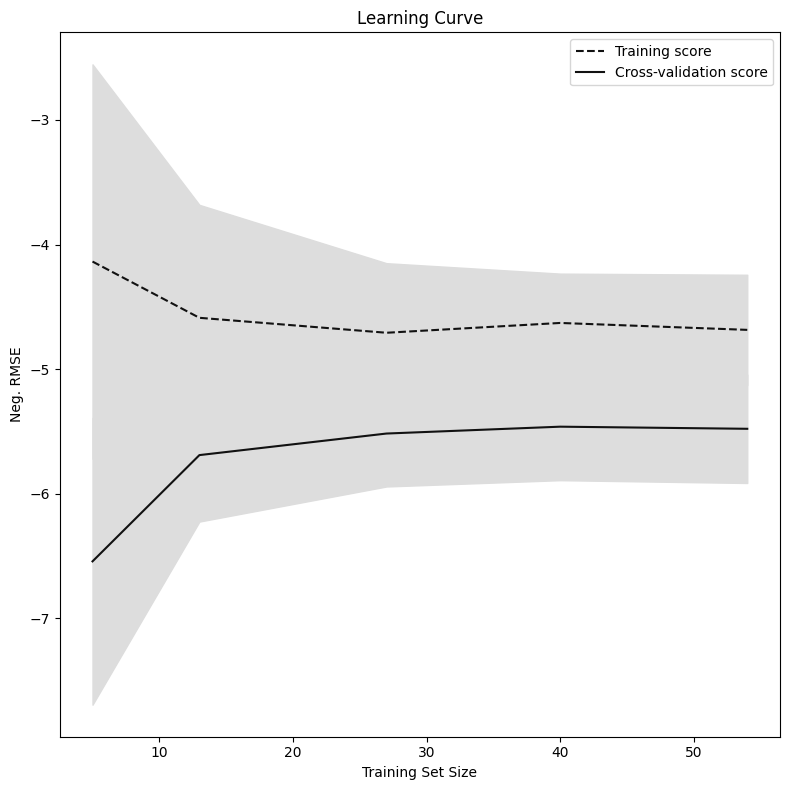

Best RMSE:  16.200201697370368


Params:  {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}


In [ ]:
#Train Columbus, Test Denver, with Columbus Data
models_svr_Region(dfc_c,dfd_c,'brightness')


Kernel is not linear


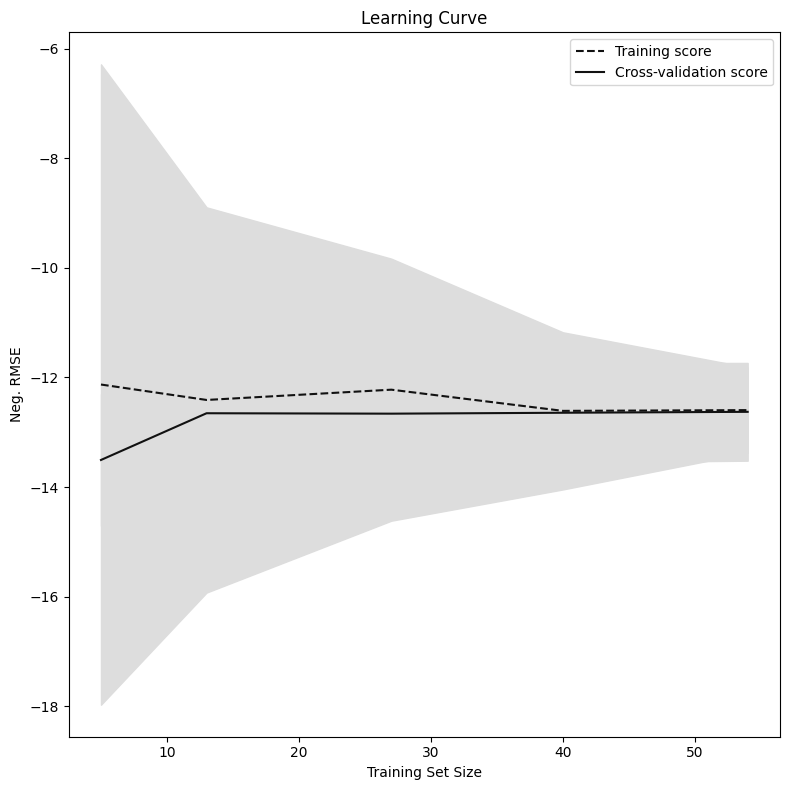

Best RMSE:  8.868005742635011


Params:  {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}


In [ ]:
#Train Denver, Test Columbus, with Columbus Data
models_svr_Region(dfd_c,dfc_c,'brightness')

Kernel is not linear


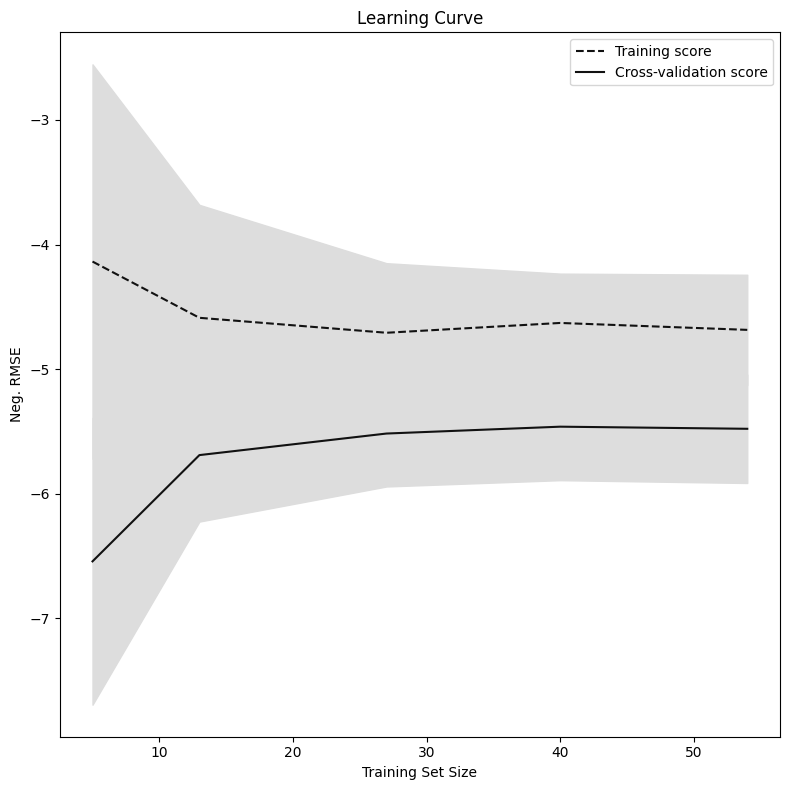

Best RMSE:  16.200201697370368


Params:  {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}


In [ ]:
#Train Columbus, Test Denver, with Denver Data
models_svr_Region(dfc_d,dfd_d,'brightness')

Kernel is not linear


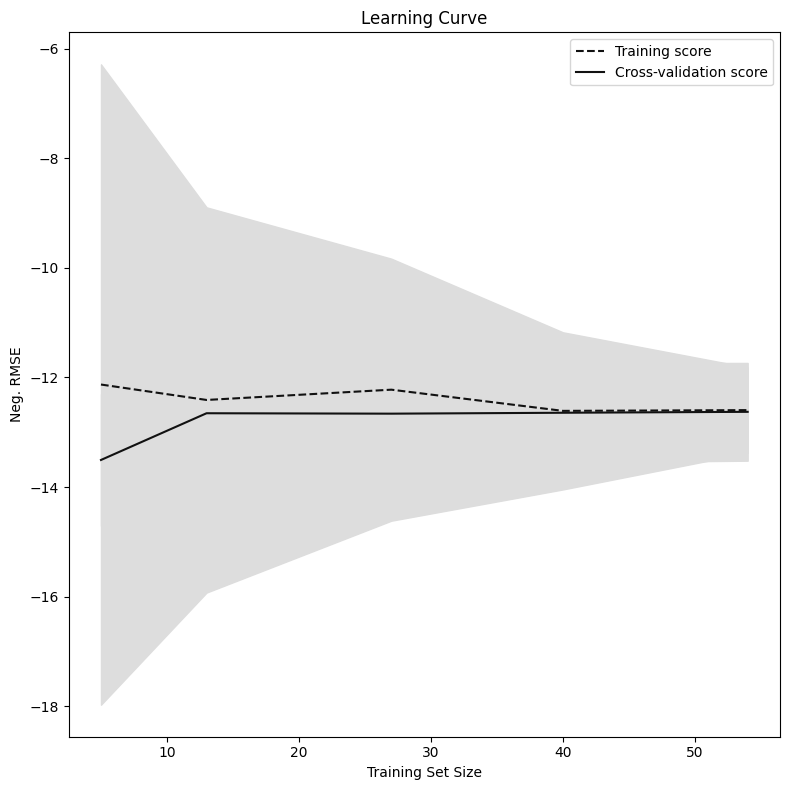

Best RMSE:  8.868005742635011


Params:  {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}


In [ ]:
#Train Denver, Test Columbus, with Denver Data
models_svr_Region(dfd_d,dfc_d,'brightness')

#Forced Linear for Feature Importance

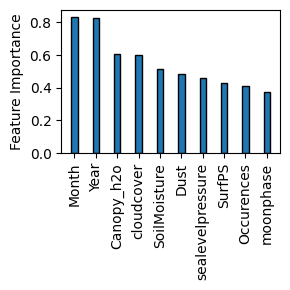

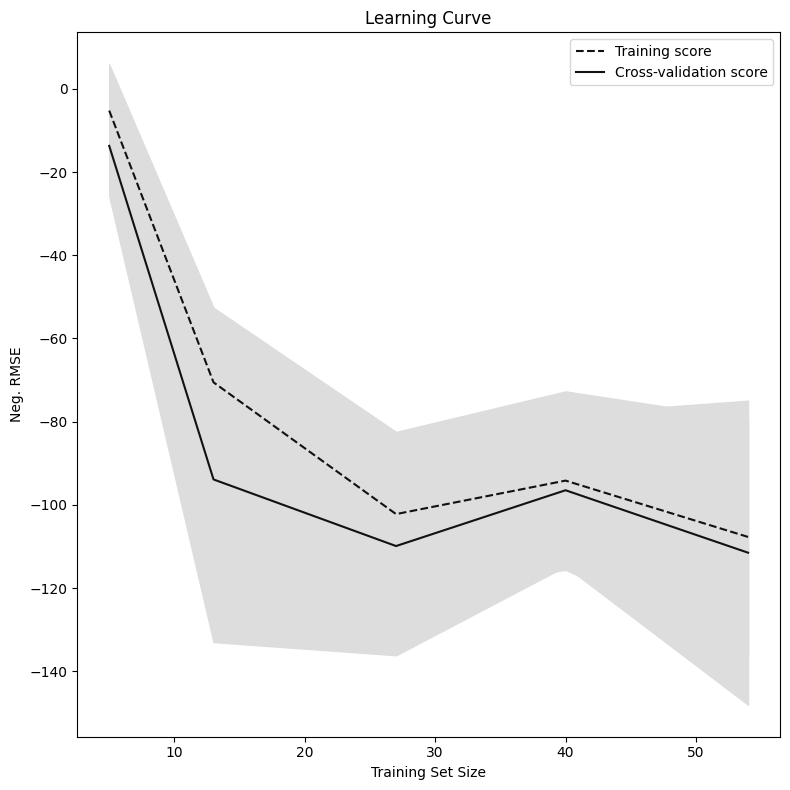

Best RMSE:  33275.550589821156


Params:  {'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'}


In [ ]:
#Train Columbus, Test Denver, with Columbus Data
models_svr_Region_force_L(dfc_c,dfd_c,'brightness')

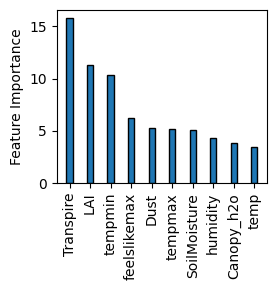

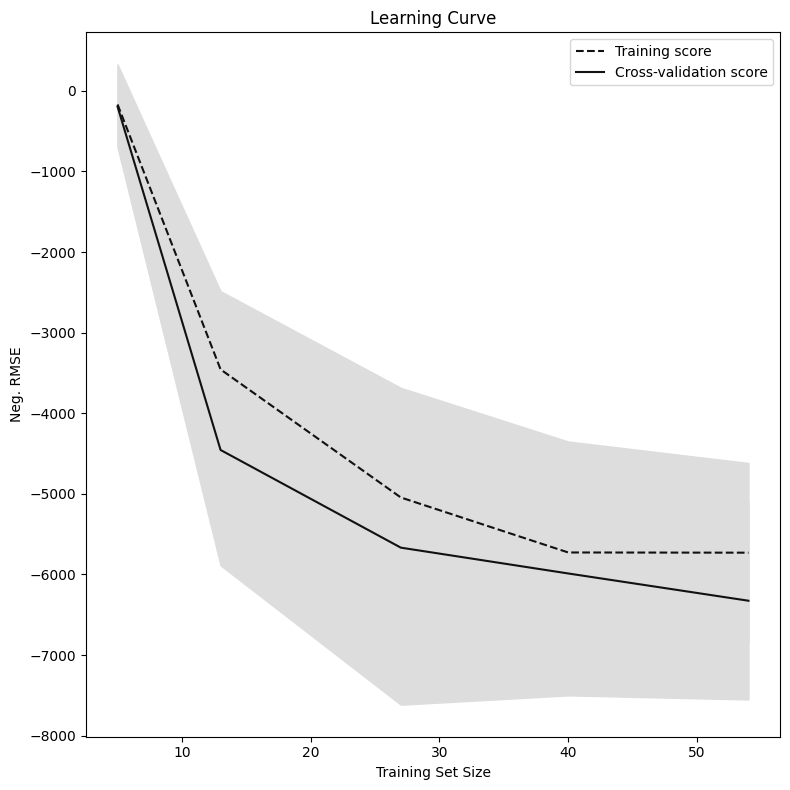

Best RMSE:  115282.95289296456


Params:  {'C': 10, 'gamma': 0.001, 'kernel': 'linear'}


In [ ]:
#Train Denver, Test Columbus, with Columbus Data
models_svr_Region_force_L(dfd_c,dfc_c,'brightness')

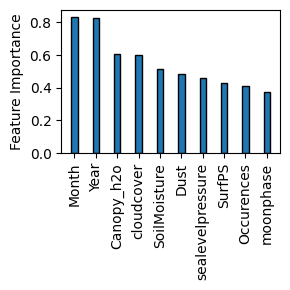

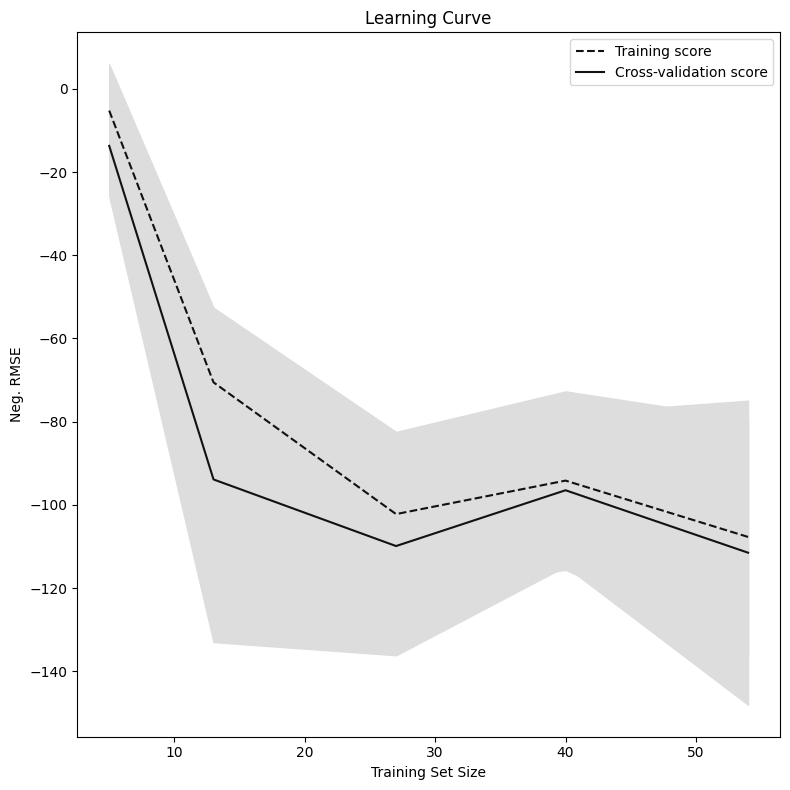

Best RMSE:  33275.550589821156


Params:  {'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'}


In [ ]:
#Train Columbus, Test Denver, with Denver Data
models_svr_Region_force_L(dfc_d,dfd_d,'brightness')

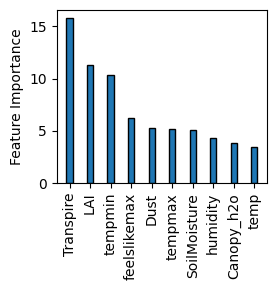

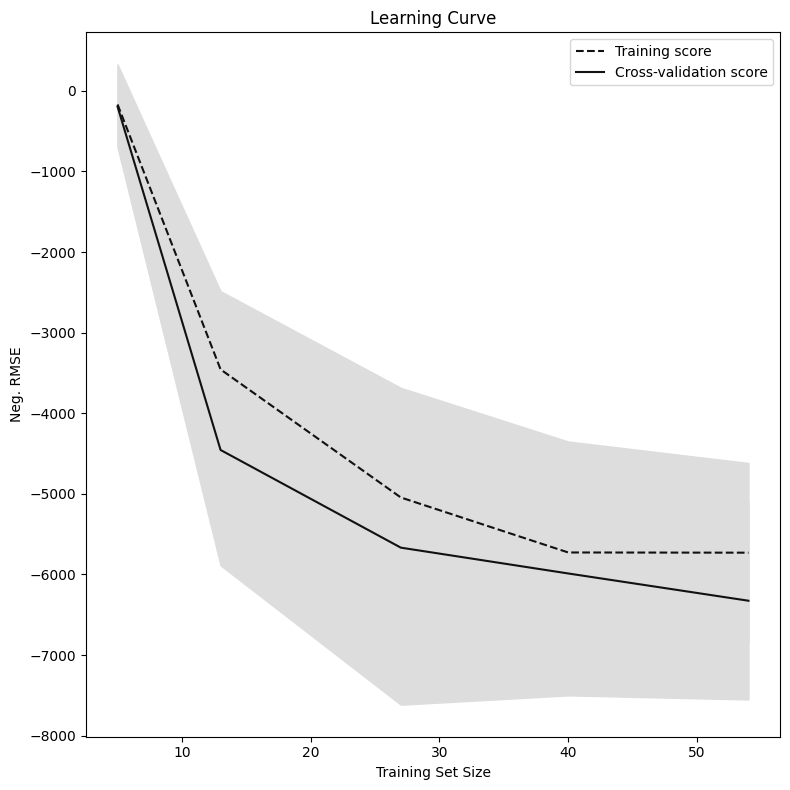

Best RMSE:  115282.95289296456


Params:  {'C': 10, 'gamma': 0.001, 'kernel': 'linear'}


In [ ]:
#Train Denver, Test Columbus, with Denver Data
models_svr_Region_force_L(dfd_d,dfc_d,'brightness')